In [24]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import PIL.Image as Image

In [19]:
vgg = VGG16(input_shape=(img_size, img_size, 3), weights='imagenet', include_top=False)

In [3]:
vgg = VGG16(input_shape=(img_size, img_size, 3), weights='imagenet', include_top=False)

In [20]:
#weights have been already fixed - there is no training
for layer in vgg.layers:
    layer.trainable = False

In [22]:
import pathlib
data_dir =pathlib.Path("dataset")

In [23]:
retina_images_dict = {
    'mild' : list(data_dir.glob('Mild/*')),
    'moderate' : list(data_dir.glob('Moderate/*')),
    'no_dr' : list(data_dir.glob('No_DR/*')),
    'proliferate_dr' : list(data_dir.glob('Proliferate_DR/*')),
    'severe' : list(data_dir.glob('Severe/*')),
}

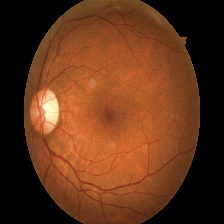

In [25]:
Image.open(str(retina_images_dict['mild'][0]))

In [28]:
retina_labels_dict = {
    'mild' : 0,
    'moderate' : 1,
    'no_dr' : 2,
    'proliferate_dr' : 3,
    'severe' : 4
}

In [30]:
img = cv2.imread(str(retina_images_dict['mild'][0]))

In [31]:
img.shape

(224, 224, 3)

In [33]:
x, y = [], []
for dr_type, images in retina_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img, IMAGE_SHAPE)
        x.append(resized_img)
        y.append(retina_labels_dict[dr_type])

In [34]:
x = np.array(x)/255

MemoryError: Unable to allocate 34.8 GiB for an array with shape (31041, 224, 224, 3) and data type float64

In [40]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=0)

In [41]:
xval, xtest, yval, ytest = train_test_split(xtest, ytest, test_size=0.5, random_state=0)

In [42]:
predicted = vgg.predict(np.array([x[0], x[1]]))
predicted = np.argmax(predicted, axis=1)

1/1 [==============================] - 1s 845ms/step


In [43]:
predicted

array([[[0, 0, 0, ..., 3, 6, 0],
        [2, 0, 1, ..., 3, 6, 0],
        [1, 0, 1, ..., 0, 6, 0],
        ...,
        [4, 0, 1, ..., 1, 0, 0],
        [4, 0, 1, ..., 1, 6, 0],
        [0, 0, 0, ..., 0, 6, 0]],

       [[0, 0, 0, ..., 0, 6, 0],
        [2, 0, 2, ..., 0, 6, 0],
        [1, 0, 2, ..., 0, 0, 0],
        ...,
        [5, 0, 1, ..., 0, 1, 0],
        [2, 0, 1, ..., 0, 1, 0],
        [0, 0, 0, ..., 0, 6, 0]]], dtype=int64)

In [35]:
pretrained_model_without_top_layer = hub.KerasLayer(
vgg, input_shape=(224, 224, 3), trainable=False)

In [37]:
type_dr = 5
model = tf.keras.Sequential([
    pretrained_model_without_top_layer,
    tf.keras.layers.Dense(type_dr)
])
model.summary()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 7, 7, 512)         14714688  
                                                                 
 dense_1 (Dense)             (None, 7, 7, 5)           2565      
                                                                 
Total params: 14,717,253
Trainable params: 2,565
Non-trainable params: 14,714,688
_________________________________________________________________


In [38]:
model.compile(
optimizer='adam',
loss = 'sparse_categorical_crossentropy',
metrics = ['accuracy'])

In [44]:
r = model.fit(
  xtrain, ytrain,
  validation_data=(xval, yval),
  epochs=5,
)

ValueError: Failed to find data adapter that can handle input: (<class 'list'> containing values of types {"<class 'numpy.ndarray'>"}), (<class 'list'> containing values of types {"<class 'int'>"})